In [20]:
%matplotlib inline

from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy.stats import linregress
from target import build_tgt_matrix
np.set_printoptions(suppress=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
source = '/home/sobolev/nevermind/Andrey/data'
report = '/home/sobolev/nevermind/Andrey/analysis/PSTH'

selected_sessions = [
# new PPC sessions
'009266_hippoSIT_2023-04-17_17-04-17',  # ch17, 20 + 55 correction, 5067 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-18_10-10-37',  # ch17, 10 + 55 correction, 5682 events
'009266_hippoSIT_2023-04-18_17-03-10',  # ch17, 6 + 55 correction, 5494 events: FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-19_10-33-51',  # ch17, 4 + 55 correction, 6424 events: very weird 1-2nd in target, find out
'009266_hippoSIT_2023-04-20_08-57-39',  # ch1, 1 + 55 correction, 6424 events. Showcase for N2 / N3 mod in target
'009266_hippoSIT_2023-04-24_16-56-55',  # ch17, 5 + 55* correction, 6165 events, frequency
'009266_hippoSIT_2023-04-26_08-20-17',  # ch17, 12 + 55* correction, 6095 events, duration - showcase for N2 
'009266_hippoSIT_2023-05-02_12-22-14',  # ch20, 10 + 55 correction, 5976 events, FIXME very weird 1-2nd in target, find out
'009266_hippoSIT_2023-05-04_09-11-06',  # ch17, 5 + 55* correction, 4487 events, coma session with baseline AEPs
'009266_hippoSIT_2023-05-04_19-47-15',  # ch20, 2 + 55 correction, 5678 events, duration

# Old PPC sessions
'008229_hippoSIT_2022-05-17_21-44-43',  # chs: 0, 31, 54, 56
'008229_hippoSIT_2022-05-16_20-36-44',  # chs: 0, 56
'008229_hippoSIT_2022-05-20_15-54-39',  # chs: 0, 56
'008229_hippoSIT_2022-05-18_14-36-18',  # chs: 0, 56
]

session = selected_sessions[0]
area = 'A1'

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5name      = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, session)
if not os.path.exists(report_path):
    os.makedirs(report_path)

In [89]:
def get_spike_counts_per_AEP(spk_times, pulse_times, off_start, off_end):
    collected = []
    for t_pulse in pulse_times:
        selected = spk_times[(spk_times > t_pulse + off_start) & (spk_times < t_pulse + off_end)]
        collected.append(len(selected))
    return np.array(collected)

In [90]:
def plot_scatter_by_metric(metric, example_units):
    unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
    rows = int(np.ceil(unit_count/3))
    fig = plt.figure(figsize=(15, rows*4))
    count = 0

    for session, unit_ids in example_units.items():
        # read AEP events
        animal    = session.split('_')[0]
        aeps_file = os.path.join(source, animal, session, 'AEPs.h5')
        with h5py.File(aeps_file, 'r') as f:
            aeps_events = np.array(f['aeps_events'])
            aeps = np.array(f[area]['aeps'])

        # TODO find better way. Remove outliers
        aeps[aeps > 5000]  =  5000
        aeps[aeps < -5000] = -5000

        # read single units
        spike_times = {}
        h5_file = os.path.join(source, animal, session, session + '.h5')
        with h5py.File(h5_file, 'r') as f:
            for unit_id in unit_ids:
                spike_times[unit_id] = np.array(f['units'][unit_id][H5NAMES.spike_times['name']])

        # load metrics
        AEP_metrics_lims = {}
        AEP_metrics_raw  = {}
        AEP_metrics_norm = {}
        with h5py.File(aeps_file, 'r') as f:
            grp = f[area]
            for metric_name in grp['raw']:
                AEP_metrics_raw[metric_name]  = np.array(grp['raw'][metric_name])
                AEP_metrics_norm[metric_name] = np.array(grp['norm'][metric_name])
                AEP_metrics_lims[metric_name] = [int(x) for x in grp['raw'][metric_name].attrs['limits'].split(',')]
        
        # separate high / low AEP metric states
        predictor = AEP_metrics_norm[metric]
        low_state_idxs  = np.where(predictor < predictor.mean())[0]
        high_state_idxs = np.where(predictor > predictor.mean())[0]
        
        for unit_id in unit_ids:
            off_start = float(AEP_metrics_lims[metric][0]) / 1000  # in ms
            off_end   = float(AEP_metrics_lims[metric][1]) / 1000  # in ms
            print(off_start, off_end)
            spikes_per_AEP_low  = get_spike_counts_per_AEP(spike_times[unit_id], aeps_events[low_state_idxs][:, 0], off_start, off_end)
            spikes_per_AEP_high = get_spike_counts_per_AEP(spike_times[unit_id], aeps_events[high_state_idxs][:, 0], off_start, off_end)

            slope, intercept, r_val, p_val, _ = linregress(spikes_per_AEP_high, AEP_metrics_norm[metric][high_state_idxs])
            rl = lambda x: x*slope + intercept
            x1, x2 = spikes_per_AEP_high.min(), spikes_per_AEP_high.max()

            ax = fig.add_subplot(rows, 3, count+1)
            ax.scatter(spikes_per_AEP_low, AEP_metrics_norm[metric][low_state_idxs], alpha=0.3, color='black')
            ax.scatter(spikes_per_AEP_high, AEP_metrics_norm[metric][high_state_idxs], alpha=0.3, color='red')
            #ax.plot([x1, x2], [rl(x1), rl(x2)])
            #ax.set_xlim(0, 30)
            ax.set_title("%s - R: %.2f, P: %.4f" % (unit_id, r_val, p_val), fontsize=14)
            count += 1

## On-units vs AEPs P1

In [79]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-2', '1-3', '1-4', '1-5', '1-6', '1-9', '1-12', '1-13', '1-15', '2-2', '2-3'
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-2', '1-3', '1-4', '1-9', '1-10', '2-2', '2-5', '2-7', '2-8', '2-11', '2-12'
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-2', '1-3', '1-6', '1-8', '1-9', '1-10', '1-12', '1-13', '2-2', '2-5', '2-6'
    ],
}

example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-2', '1-3'
    ]
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

2

0.015 0.025
0.015 0.025


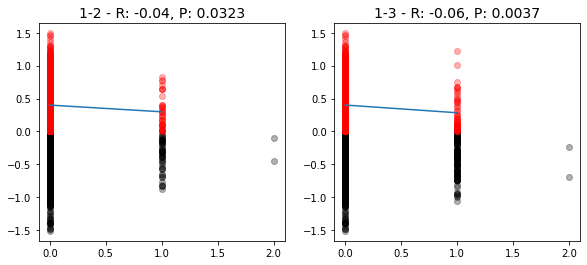

In [80]:
plot_scatter_by_metric('P1', example_units)

In [58]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-2', '1-6', '1-9', '1-10', '1-11', '1-13', '1-15'
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-5', '1-8', '2-3', '2-10', '2-12'
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-2', '1-7', '1-11', '1-12', '1-16', '1-18', '2-3', '2-5', '2-9'
    ],
}

example_units = {
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '2-3'
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '2-9'
    ],
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

2

0.03 0.075
0.03 0.075


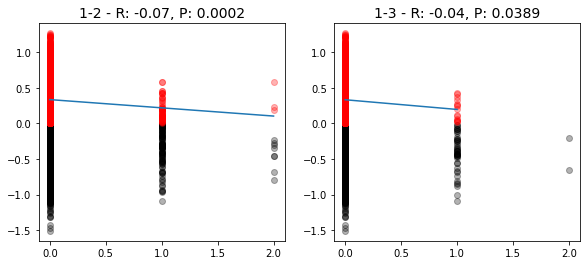

In [84]:
plot_scatter_by_metric('N1', example_units)

In [42]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-7', '1-10', '1-11', '1-12', '1-13', '1-14',
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-3', '1-6', '1-8', '2-2', '2-3', '2-4', '2-6', '2-9', '2-10', '2-11', '2-13', '2-14', 
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-13', '1-18', '2-11', '2-2', '2-3', '2-4', '2-6', '2-7', '2-9'
    ],
    '009266_hippoSIT_2023-04-19_10-33-51': [
        '1-2', '1-3', '2-2', '2-5', '2-6'
    ]
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

32

0.075 0.095
0.075 0.095


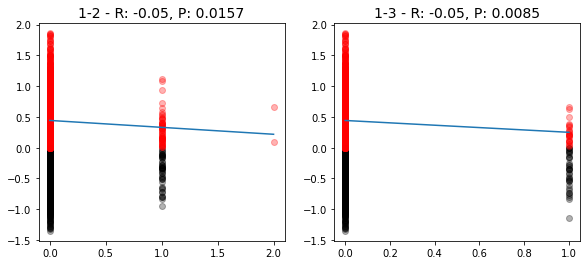

In [85]:
plot_scatter_by_metric('P2', example_units)

In [44]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-3', '1-7', '1-12'
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-2', '2-4', '2-5', '2-6', '2-9', '2-13', '2-14', 
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-5', '1-8', '1-13', '1-14', '1-16', '1-18', '2-2', '2-8', '2-9'
    ],
    '009266_hippoSIT_2023-04-19_10-33-51': [
        '1-2', '1-3', '1-4', '1-5', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '1-14', '1-16', \
        '1-19', '2-4'
    ]
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

42

0.095 0.175
0.095 0.175


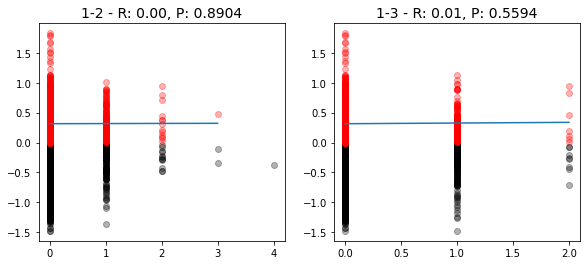

In [86]:
plot_scatter_by_metric('P3', example_units)